# Microsimulation with artificial survey data 

In [1]:
import matplotlib.pyplot as plt  # For graphics
%matplotlib inline

import numpy as np  # linear algebra and math
import pandas as pd  # data frames

from openfisca_core.model_api import *
from openfisca_senegal import CountryTaxBenefitSystem as SenegalTaxBenefitSystem  # The Senegalese tax-benefits system

from openfisca_senegal.survey_scenarios import SenegalSurveyScenario

## Building the artificial data

Sénégal is composed by almost 15 millions people dispatched in around 1.6 million household

In [2]:
year = 2017
household_weight = 100
size = int(1.6e6 / household_weight)
print("Size of the sample: {}".format(size))
np.random.seed(seed = 42)

Size of the sample: 16000


We assume that 2/3 of the household heads are married and that only married houshold do have children. The mean number of children per household is 5 and is normally distributed

In [3]:
est_marie = np.random.binomial(1, .66, size = size)
est_celibataire = np.logical_not(est_marie)
nombre_enfants = np.maximum(
    est_marie * np.round(np.random.normal(5, scale = 3, size = size)),
    0,
    )

We assume that 80% of the population are wage earners.
We choose a mean wage of 5 000 0000 CFA with a log normal ditribution.
Since 
$$ \text{mean wage}  = e^{\mu + \frac{\sigma ^ 2}{2}} $$ 
and
$$ \text{median wage} = e^\mu $$
we can compute the distribution according to the following expressions.

In [4]:
mean_wage = 5e6
median_wage = .75 * mean_wage
est_salarie = np.random.binomial(1, .8, size = size)
mu = np.log(median_wage)
sigma = np.sqrt(2 * np.log(mean_wage / median_wage))
salaire = (
    est_salarie *
    np.random.lognormal(mean = mu, sigma = sigma, size = int(size))
    )


We choose a mean pension of 2 500 000 CFA

In [5]:
mean_pension = 2.5e6
median_pension = .9 * mean_pension

In [6]:
mu = np.log(median_pension)
sigma = np.sqrt(2 * np.log(mean_pension / median_pension))
pension_retraite = (
    np.logical_not(est_salarie) *
    np.random.lognormal(mean = mu, sigma = sigma, size = int(size))
    )

In [7]:
input_data_frame = pd.DataFrame({
    'est_marie': est_marie,
    'est_celibataire': est_celibataire,
    'nombre_enfants': nombre_enfants,
    'pension_retraite': pension_retraite,
    'salaire': salaire,
    'household_id': range(size),
    'household_role_index': 0,
    'household_weight': household_weight,
    'person_weight': household_weight,
    })

<Axes: >

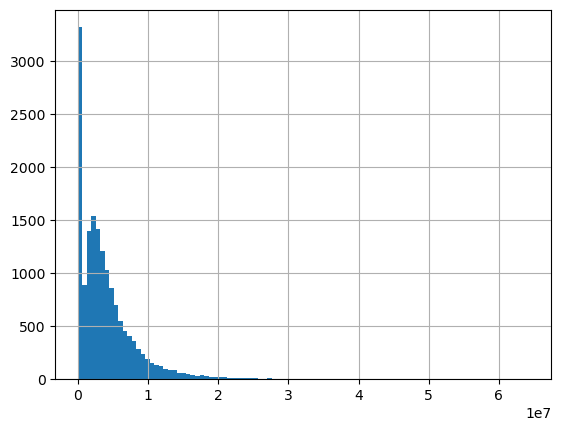

In [8]:
input_data_frame.salaire.hist(bins=100)

<Axes: >

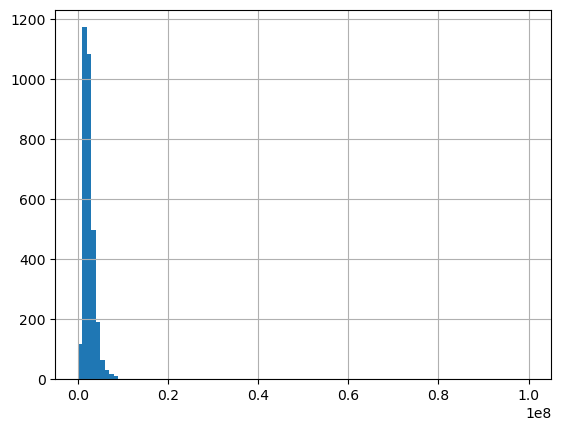

In [9]:
input_data_frame.pension_retraite.hist(bins=100, range = [.0001, 1e8])

## Microsimulation 

As with test case, we can build a scenario with survey data

In [10]:
data = dict(input_data_frame = input_data_frame)
scenario = SenegalSurveyScenario(
    period = year,
    data = data,
    )

We can compute the value of any variable for the whole population an draw distributions

In [11]:
scenario.simulations["baseline"].calculate('impot_revenus', period = year)

array([     0., 221100., 974400., ..., 233100., 933800., 309600.],
      dtype=float32)

In [12]:
df = pd.DataFrame({'impot_revenus': scenario.simulations["baseline"].calculate('impot_revenus', period = year)})

array([[<Axes: title={'center': 'impot_revenus'}>]], dtype=object)

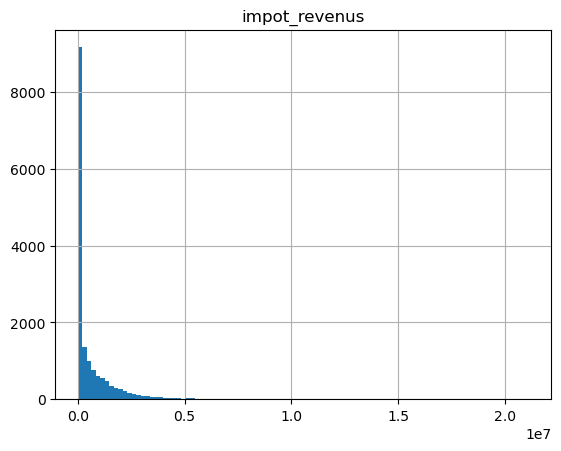

In [13]:
df.hist(bins = 100)

Special methods allow access to aggregates and pivot tables

In [14]:
scenario.compute_aggregate('impot_revenus', period = year) / 1e9

967.3534237

c:\users\s.duchesne\desktop\github\openfisca-survey-manager\openfisca_survey_manager\simulations.py:470: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame[value].fillna(missing_variable_default_value, inplace = True)


<Axes: xlabel='nombre_enfants'>

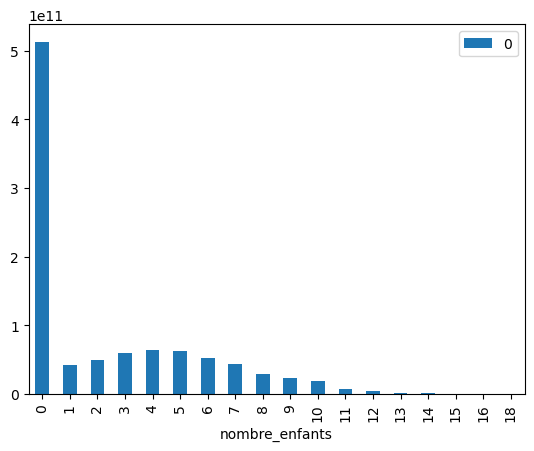

In [15]:
scenario.compute_pivot_table(
    aggfunc = 'sum',
    values = ['impot_revenus'],
    columns = ['nombre_enfants'],
    period = year,
    ).stack().reset_index().plot(x = 'nombre_enfants', kind = 'bar')

# Evaluate the financial impact of a reform

Write a parametric reform tthat increseases the top marginal tax rates and evaluate how much revenue can be collected

In [16]:
def modify_parameters(parameters):
    parameters.prelevements_obligatoires.impots_directs.bareme_impot_progressif[5].rate.update(period = period(year), value = .5)
    return parameters

class tax_the_rich(Reform):
    name = u"Tax last bracket at 50%"

    def apply(self):
        self.modify_parameters(modifier_function = modify_parameters)

In [17]:
senegal_tax_benefit_system = SenegalTaxBenefitSystem()
tax_the_rich_tax_benefit_system = tax_the_rich(senegal_tax_benefit_system)

In [18]:
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = tax_the_rich_tax_benefit_system,
    baseline_tax_benefit_system = senegal_tax_benefit_system,
    period = year,
    )

In [19]:
print('reform tax the rich: ', scenario.compute_aggregate('impot_revenus', period = year) / 1e9)
print('baseline: ', scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year) / 1e9)

reform tax the rich:  993.1257657
baseline:  967.3534237


In [20]:
from openfisca_senegal.entities import Person

def build_ultimate_reform_tax_benefit_system(seuil = 0, marginal_tax_rate = .4):

    senegal_tax_benefit_system = SenegalTaxBenefitSystem()
    class impot_revenus(Variable):
        def formula(individu, period):
            impot_avant_reduction_famille = individu('impot_avant_reduction_famille', period)
            reduction_impots_pour_charge_famille = individu('reduction_impots_pour_charge_famille', period)
            impot_apres_reduction_famille = impot_avant_reduction_famille - reduction_impots_pour_charge_famille
            impot_revenus = max_(0, impot_apres_reduction_famille)
            return impot_revenus * (impot_revenus > seuil)

    def modify_parameters(parameters):
        parameters.prelevements_obligatoires.impots_directs.bareme_impot_progressif[5].rate.update(
            period = period(year), value = marginal_tax_rate)
        return parameters


    class ultimate_reform(Reform):
        name = u"Tax the rich and save the poor taxpayers (tax < {})".format(seuil)

        def apply(self):
            self.update_variable(impot_revenus)
            self.modify_parameters(modifier_function = modify_parameters)

    return ultimate_reform(senegal_tax_benefit_system)

In [21]:
reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(seuil = 100000, marginal_tax_rate = .45)

In [22]:
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
    period = year,
    )

In [23]:
print('reform: ', scenario.compute_aggregate('impot_revenus', period = year) / 1e9)
print('baseline: ', scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year) / 1e9)

reform:  975.32188845
baseline:  967.3534237


In [24]:
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system =  SenegalTaxBenefitSystem(),
    period = year,
    )
print(scenario.compute_aggregate('impot_revenus', period = year) / 1e9)
print(scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year) / 1e9)
cost = - (
    scenario.compute_aggregate('impot_revenus', period = year) -
    scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year)
    ) / 1e9
print(cost)

975.32188845
967.3534237
-7.96846475


In [25]:
def compute_reform_cost(seuil):
    reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(
        seuil = seuil,
        marginal_tax_rate = .41
        )
    scenario = SenegalSurveyScenario(
        data = data,
        tax_benefit_system = reformed_tax_benefit_system,
        baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
        period = year,
        )
    cost = - (
        scenario.compute_aggregate('impot_revenus', period = year) -
        scenario.compute_aggregate('impot_revenus', use_baseline = True, period = year)
        ) / 1e9
    return cost

In [26]:
compute_reform_cost(seuil = 100000)

2.30983005

In [27]:
from scipy.optimize import fsolve
x = fsolve(compute_reform_cost, 100000)
x

C:\Users\s.duchesne\AppData\Local\Temp\ipykernel_17360\2414072184.py:2: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x = fsolve(compute_reform_cost, 100000)


array([71562.81479822])

In [28]:
compute_reform_cost(seuil = x)

0.00353005

In [29]:
reformed_tax_benefit_system = build_ultimate_reform_tax_benefit_system(
        seuil = x,
        marginal_tax_rate = .41
        )
scenario = SenegalSurveyScenario(
    data = data,
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = SenegalTaxBenefitSystem(),
    period = year,
    )

c:\users\s.duchesne\desktop\github\openfisca-survey-manager\openfisca_survey_manager\simulations.py:470: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame[value].fillna(missing_variable_default_value, inplace = True)


<Axes: xlabel='nombre_enfants'>

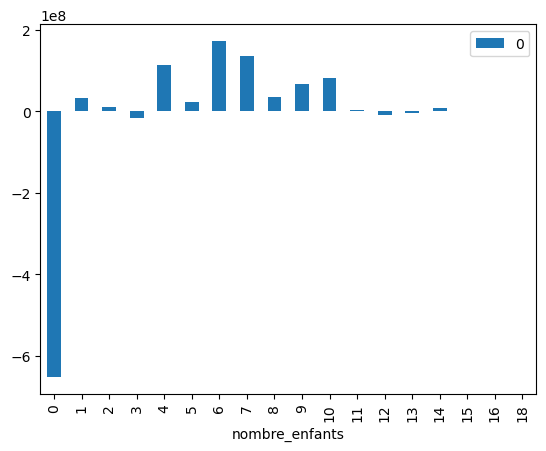

In [30]:
scenario.compute_pivot_table(
    aggfunc = 'sum',
    values = ['impot_revenus'],
    columns = ['nombre_enfants'],
    period = year,
    difference = True,
    ).stack().reset_index().plot(x = 'nombre_enfants', kind = 'bar')